# MNIST Digit Classification with our own Framework

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [7]:
!rm *.pkl
!wget https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/data/mnist.pkl.gz
!gzip -d mnist.pkl.gz

rm: cannot remove '*.pkl': No such file or directory
--2025-07-22 12:13:05--  https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/data/mnist.pkl.gz


Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  --.-KB/s    in 0.1s    

2025-07-22 12:13:05 (135 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [8]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f,  encoding='latin1')

In [9]:
training_set, validation_set, test_set = MNIST
data, labels = training_set

Let's see what is the shape of data that we have:

In [10]:
data.shape

(50000, 784)

### Splitting the Data

We will use Scikit Learn to split the data between training and test dataset:

In [11]:
features_train, labels_train = data, labels
features_test, labels_test = test_set

print(f"Train samples: {len(features_train)}, test samples: {len(features_test)}")

Train samples: 50000, test samples: 10000


In [12]:
val_data, val_labels = validation_set

### Instructions

1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module
1. Define and train one-layered perceptron, observing training and validation accuracy during training
1. Try to understand if overfitting took place, and adjust layer parameters to improve accuracy
1. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.
1. Try to answer the following questions:
    - Does the inter-layer activation function affect network performance?
    - Do we need 2- or 3-layered network for this task?
    - Did you experience any problems training the network? Especially as the number of layers increased.
    - How do weights of the network behave during training? You may plot max abs value of weights vs. epoch to understand the relation.

In [17]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [18]:
import importlib
import tensorflow as tf
importlib.reload(tf)

2025-07-22 12:19:08.164813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753186748.537011    1715 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753186748.641409    1715 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<module 'tensorflow' from '/usr/local/lib/python3.11/dist-packages/tensorflow/__init__.py'>

In [86]:
import importlib
import tensorflow_net
importlib.reload(tensorflow_net)

<module 'tensorflow_net' from '/kaggle/working/tensorflow_net.py'>

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"    
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" 


from tensorflow_net import Net, PerceptronLayer, CrossEntropyLoss, Softmax
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with strategy.scope(): 
    net = Net()
    net.add(PerceptronLayer(784, 10))
    loss_fn = CrossEntropyLoss()
    softmax = Softmax()
import matplotlib.pyplot as plt

In [74]:
def train(net, features_train, labels_train,
          val_data, val_labels,
          epochs=5, lr=0.1, batch_size=128):

    dataset = tf.data.Dataset.from_tensor_slices(
        (features_train.astype("float32"), labels_train.astype("int32"))
    ).shuffle(len(features_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    max_abs_weights_history = []

    for epoch in range(epochs):
        for X_batch, y_batch in dataset:
            def step_fn(inputs):
                X, y = inputs
                with tf.GradientTape() as tape:
                    logits = net.forward(X)
                    loss = loss_fn.forward(logits, y)
                grad_logits = loss_fn.backward()
                net.backward(grad_logits)
                net.update(lr)
                return loss

            per_replica_loss = strategy.run(step_fn, args=((X_batch, y_batch),))
            epoch_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN,
                                         per_replica_loss, axis=None)

        current_max_weight = 0.0
        for layer in net.layers:
            if hasattr(layer, "weights"):
                max_in_layer = tf.reduce_max(tf.abs(layer.weights)).numpy()
                if max_in_layer > current_max_weight:
                    current_max_weight = max_in_layer
        
        max_abs_weights_history.append(current_max_weight)

        train_preds = tf.argmax(softmax(net.forward(features_train)), axis=1)
        train_acc = tf.reduce_mean(
            tf.cast(train_preds == labels_train, tf.float32)
        )

        val_preds = tf.argmax(softmax(net.forward(val_data)), axis=1)
        val_acc = tf.reduce_mean(
            tf.cast(val_preds == val_labels, tf.float32)
        )

        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, "
              f"Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
    return max_abs_weights_history

In [60]:
weights_history = train(features_train, labels_train, val_data, val_labels,
          epochs=100, lr=0.01, batch_size=128)

Epoch 1: Loss = 0.2140, Train Acc = 0.9054, Val Acc = 0.9147
Epoch 2: Loss = 0.4947, Train Acc = 0.9061, Val Acc = 0.9146
Epoch 3: Loss = 0.2048, Train Acc = 0.9065, Val Acc = 0.9153
Epoch 4: Loss = 0.3517, Train Acc = 0.9071, Val Acc = 0.9154
Epoch 5: Loss = 0.2221, Train Acc = 0.9072, Val Acc = 0.9154
Epoch 6: Loss = 0.2803, Train Acc = 0.9077, Val Acc = 0.9154
Epoch 7: Loss = 0.4568, Train Acc = 0.9077, Val Acc = 0.9159
Epoch 8: Loss = 0.3931, Train Acc = 0.9080, Val Acc = 0.9164
Epoch 9: Loss = 0.2196, Train Acc = 0.9085, Val Acc = 0.9171
Epoch 10: Loss = 0.3488, Train Acc = 0.9088, Val Acc = 0.9165
Epoch 11: Loss = 0.3438, Train Acc = 0.9091, Val Acc = 0.9172
Epoch 12: Loss = 0.3428, Train Acc = 0.9094, Val Acc = 0.9170
Epoch 13: Loss = 0.2741, Train Acc = 0.9099, Val Acc = 0.9174
Epoch 14: Loss = 0.2261, Train Acc = 0.9099, Val Acc = 0.9173
Epoch 15: Loss = 0.3141, Train Acc = 0.9103, Val Acc = 0.9178
Epoch 16: Loss = 0.3078, Train Acc = 0.9104, Val Acc = 0.9178
Epoch 17: Loss = 

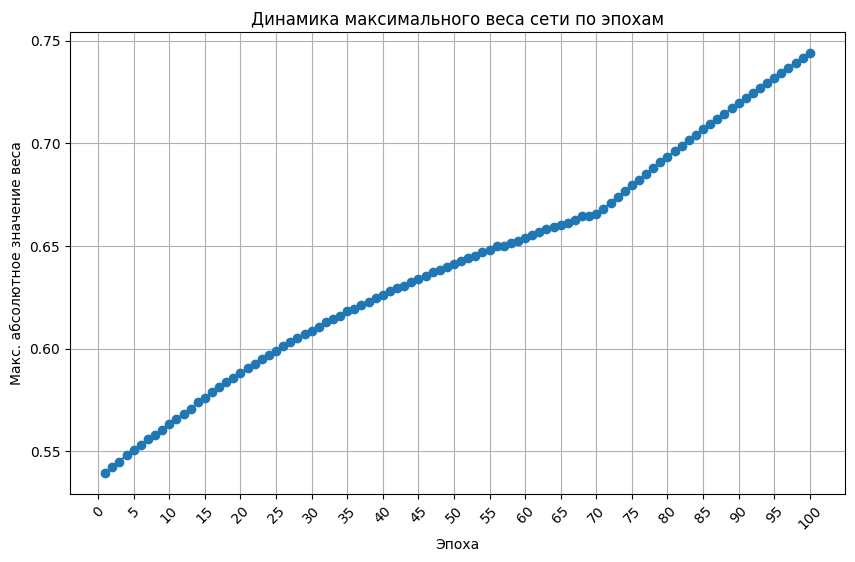

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100 + 1), weights_history, marker='o', linestyle='-')
plt.title('Динамика максимального веса сети по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Макс. абсолютное значение веса')
plt.grid(True)
plt.xticks(range(0, 101, 5), rotation=45)
plt.show()

In [67]:
weight_history = train(features_train, labels_train, val_data, val_labels,
          epochs=100, lr=0.5, batch_size=256)

Epoch 1: Loss = 0.3185, Train Acc = 0.9001, Val Acc = 0.9111
Epoch 2: Loss = 0.3222, Train Acc = 0.9093, Val Acc = 0.9161
Epoch 3: Loss = 0.3495, Train Acc = 0.9119, Val Acc = 0.9172
Epoch 4: Loss = 0.3091, Train Acc = 0.9135, Val Acc = 0.9189
Epoch 5: Loss = 0.2121, Train Acc = 0.9159, Val Acc = 0.9191
Epoch 6: Loss = 0.3310, Train Acc = 0.9200, Val Acc = 0.9249
Epoch 7: Loss = 0.3959, Train Acc = 0.9170, Val Acc = 0.9216
Epoch 8: Loss = 0.1645, Train Acc = 0.9210, Val Acc = 0.9221
Epoch 9: Loss = 0.3062, Train Acc = 0.9211, Val Acc = 0.9222
Epoch 10: Loss = 0.3473, Train Acc = 0.9150, Val Acc = 0.9199
Epoch 11: Loss = 0.3453, Train Acc = 0.9217, Val Acc = 0.9240
Epoch 12: Loss = 0.2213, Train Acc = 0.9243, Val Acc = 0.9274
Epoch 13: Loss = 0.3924, Train Acc = 0.9247, Val Acc = 0.9256
Epoch 14: Loss = 0.1871, Train Acc = 0.9235, Val Acc = 0.9231
Epoch 15: Loss = 0.3410, Train Acc = 0.9224, Val Acc = 0.9235
Epoch 16: Loss = 0.1100, Train Acc = 0.9243, Val Acc = 0.9245
Epoch 17: Loss = 

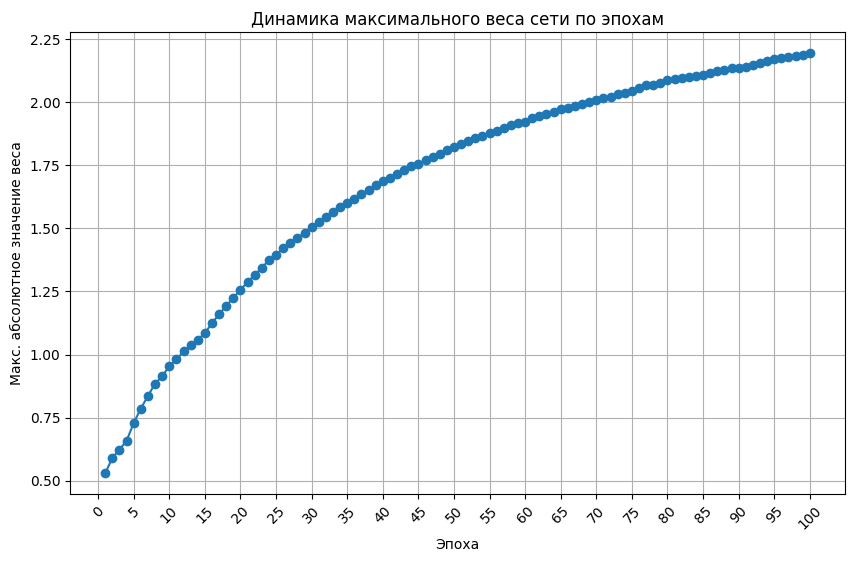

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100 + 1), weight_history, marker='o', linestyle='-')
plt.title('Динамика максимального веса сети по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Макс. абсолютное значение веса')
plt.grid(True)
plt.xticks(range(0, 101, 5), rotation=45)
plt.show()

In [78]:
from tensorflow_net import Net, PerceptronLayer, CrossEntropyLoss, Softmax, ReLULayer

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

with strategy.scope(): 
    net_2_layer = Net()
    net_2_layer.add(PerceptronLayer(784, 256, name="fc1"))
    net_2_layer.add(ReLULayer())
    net_2_layer.add(PerceptronLayer(256, 10, name="fc2")) 
    loss_fn = CrossEntropyLoss()
    softmax = Softmax()

In [80]:
weight_history = train(net_2_layer, features_train, labels_train, val_data, val_labels,
          epochs=100, lr=0.1, batch_size=256)

Epoch 1: Loss = 0.0190, Train Acc = 0.9913, Val Acc = 0.9793
Epoch 2: Loss = 0.0195, Train Acc = 0.9915, Val Acc = 0.9795
Epoch 3: Loss = 0.0517, Train Acc = 0.9913, Val Acc = 0.9795
Epoch 4: Loss = 0.0356, Train Acc = 0.9920, Val Acc = 0.9798
Epoch 5: Loss = 0.0744, Train Acc = 0.9922, Val Acc = 0.9799
Epoch 6: Loss = 0.0683, Train Acc = 0.9924, Val Acc = 0.9790
Epoch 7: Loss = 0.0266, Train Acc = 0.9928, Val Acc = 0.9800
Epoch 8: Loss = 0.0647, Train Acc = 0.9930, Val Acc = 0.9794
Epoch 9: Loss = 0.0204, Train Acc = 0.9933, Val Acc = 0.9804
Epoch 10: Loss = 0.0415, Train Acc = 0.9935, Val Acc = 0.9803
Epoch 11: Loss = 0.0189, Train Acc = 0.9938, Val Acc = 0.9802
Epoch 12: Loss = 0.0217, Train Acc = 0.9937, Val Acc = 0.9803
Epoch 13: Loss = 0.0246, Train Acc = 0.9941, Val Acc = 0.9803
Epoch 14: Loss = 0.0144, Train Acc = 0.9945, Val Acc = 0.9805
Epoch 15: Loss = 0.0254, Train Acc = 0.9943, Val Acc = 0.9810
Epoch 16: Loss = 0.0548, Train Acc = 0.9948, Val Acc = 0.9803
Epoch 17: Loss = 

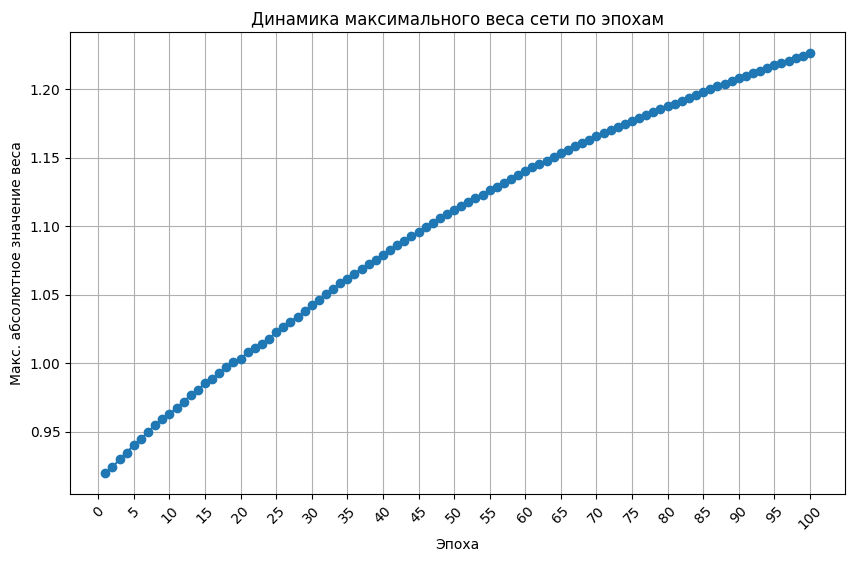

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), weight_history, marker='o', linestyle='-')
plt.title('Динамика максимального веса сети по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Макс. абсолютное значение веса')
plt.grid(True)
plt.xticks(range(0, 101, 5), rotation=45)
plt.show()

In [96]:
from tensorflow_net import Net, PerceptronLayer, CrossEntropyLoss, Softmax, ReLULayer, GELULayer

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

with strategy.scope(): 
    net_3_layer = Net()
    net_3_layer.add(PerceptronLayer(784, 256, name="fc1"))
    net_3_layer.add(ReLULayer())
    net_3_layer.add(PerceptronLayer(256, 256, name="fc2")) 
    net_3_layer.add(ReLULayer())
    net_3_layer.add(PerceptronLayer(256, 10, name="fc2")) 
    loss_fn = CrossEntropyLoss()
    softmax = Softmax()

In [97]:
weight_history = train(net_3_layer, features_train, labels_train, val_data, val_labels,
          epochs=100, lr=0.5, batch_size=512)

Epoch 1: Loss = 0.6905, Train Acc = 0.7714, Val Acc = 0.7896
Epoch 2: Loss = 0.2362, Train Acc = 0.9194, Val Acc = 0.9218
Epoch 3: Loss = 0.1498, Train Acc = 0.9430, Val Acc = 0.9464
Epoch 4: Loss = 0.2023, Train Acc = 0.9411, Val Acc = 0.9404
Epoch 5: Loss = 0.1689, Train Acc = 0.9574, Val Acc = 0.9583
Epoch 6: Loss = 0.1044, Train Acc = 0.9669, Val Acc = 0.9647
Epoch 7: Loss = 0.0780, Train Acc = 0.9735, Val Acc = 0.9699
Epoch 8: Loss = 0.0682, Train Acc = 0.9771, Val Acc = 0.9712
Epoch 9: Loss = 0.0714, Train Acc = 0.9804, Val Acc = 0.9737
Epoch 10: Loss = 0.0890, Train Acc = 0.9773, Val Acc = 0.9694
Epoch 11: Loss = 0.0758, Train Acc = 0.9769, Val Acc = 0.9689
Epoch 12: Loss = 0.0500, Train Acc = 0.9852, Val Acc = 0.9731
Epoch 13: Loss = 0.0244, Train Acc = 0.9883, Val Acc = 0.9748
Epoch 14: Loss = 0.0501, Train Acc = 0.9882, Val Acc = 0.9753
Epoch 15: Loss = 0.0364, Train Acc = 0.9921, Val Acc = 0.9756
Epoch 16: Loss = 0.0579, Train Acc = 0.9887, Val Acc = 0.9728
Epoch 17: Loss = 

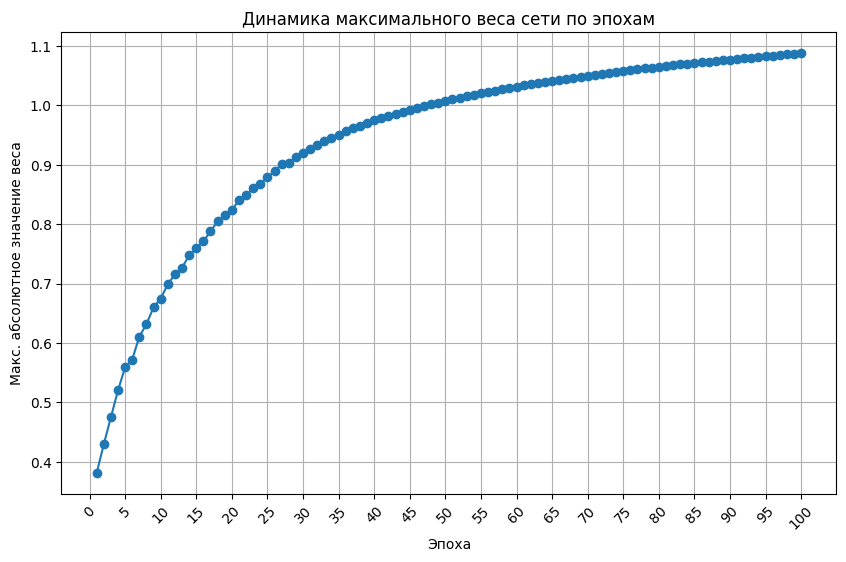

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), weight_history, marker='o', linestyle='-')
plt.title('Динамика максимального веса сети по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Макс. абсолютное значение веса')
plt.grid(True)
plt.xticks(range(0, 101, 5), rotation=45)
plt.show()

В ходе исследования я проследил эволюцию модели от линейного классификатора до многослойной нейронной сети. Однослойный перцептрон показал ограничения линейных методов, достигнув потолка в 93% точности на валидационной выборке.

Критическим открытием стала роль нелинейных активаций. Добавление второго полносвязного слоя без активации практически не улучшило результат. Однако введение ReLU между слоями привело к качественному скачку - точность возросла до ~98%. Это демонстрирует способность нелинейных функций обеспечивать иерархическое изучение признаков: первичные слои выделяют базовые паттерны, последующие формируют более сложные представления. 

Архитектурные эксперименты подтвердили эффективность глубоких сетей. Двухслойная модель обеспечила основной прирост производительности, третий слой дал дополнительное улучшение до 98.13%. Это указывает на способность дополнительной глубины извлекать более тонкие закономерности.

Наблюдалось типичное переобучение: после 15-20 эпох точность на обучающей выборке стремилась к 100%, тогда как валидационная точность выходила на плато. Анализ динамики весов показал логарифмический рост - быстрое увеличение в начале с последующим насыщением, что свидетельствует о стабильном обучении без проблемы взрывающихся градиентов.